<a href="https://colab.research.google.com/github/Gabriele90/ML-for-histopathology/blob/main/Microsatellite%20instability%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

This study aims to classify image patches derived from histological images of colorectal cancer and gastric cancer patients in the TCGA cohort (original whole slide SVS images are freely available at https://portal.gdc.cancer.gov/). All images (9267 files) in this repository are derived from formalin-fixed paraffin-embedded (FFPE) diagnostic slides ("DX" at the GDC data portal).


**Objectives**

We have 2 classes of images MSI (microsatellite instability) and MSS (microsatellite stability). Microsatellite instability determines whether patients with gastrointestinal cancer respond exceptionally well to immunotherapy. However, in clinical practice, not every patient is tested for MSI, because this requires additional genetic or immunohistochemical tests.
The correct classification through deep learning models could be essential to diagnose cancer at the right time. 
So I propose a system performing detection and classification of SVS images by making an integrated stacking ensemble model of pre-trained networks like InceptionV3, MobileNetV2, and Xception in Tensorflow.

**Importing the required libraries**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from tensorflow.keras.metrics import Metric
from typeguard import typechecked
from typing import Optional

import cv2
import random
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator

**Splitting the dataset in training, test and validation set using splitfolders**

In [4]:
!pip install split_folders
import splitfolders

In [5]:
input_folder = '/content/drive/MyDrive/HISTO'
output_folder = '/content/drive/MyDrive/output_histo'

In [6]:
splitfolders.ratio(input_folder, output_folder, seed=1337, ratio=(.8, .1, .1), group_prefix=None) 

Copying files: 9267 files [1:08:10,  2.27 files/s]


**Setting the working directories**

In [7]:
#set the path to the main dir
import os
main_dir = "/content/drive/MyDrive/output_histo"
#set the path to the train dir
train_dir = os.path.join(main_dir,'train')
#set the path to the test dir
test_dir = os.path.join(main_dir,'test')
#set the path to the val dir
val_dir = os.path.join(main_dir,'val')
#directory with the training msi images
train_msi_dir = os.path.join(train_dir, 'MSI')
#directory with the training mss images
train_mss_dir = os.path.join(train_dir, 'MSS')
#directory with the test msi images
test_msi_dir = os.path.join(test_dir, 'MSI')
#directory with the test mss images
test_mss_dir = os.path.join(test_dir, 'MSS')
#directory with the val msi images
val_msi_dir = os.path.join(val_dir, 'MSI')
#directory with the val mss images
val_mss_dir = os.path.join(val_dir, 'MSS')

In [8]:
train_msi_names = os.listdir(train_msi_dir)
print(train_msi_names[:5])

train_mss_names = os.listdir(train_mss_dir)
print(train_mss_names[:5])

test_msi_names = os.listdir(test_msi_dir)
print(test_msi_names[:5])

test_mss_names = os.listdir(test_mss_dir)
print(test_mss_names[:5])

val_msi_names = os.listdir(val_msi_dir)
print(val_msi_names[:5])

val_mss_names = os.listdir(val_mss_dir)
print(val_mss_names[:5])

['blk-DRVFAADNPPLQ-TCGA-AA-3715-01Z-00-DX1.jpg', 'blk-KQHQKSLANKTD-TCGA-A6-5661-01Z-00-DX1.jpg', 'blk-AIWDFMLESMRT-TCGA-G4-6320-01Z-00-DX1.jpg', 'blk-NVCWKGTDTIRA-TCGA-DC-6154-01Z-00-DX1.jpg', 'blk-PAISEETPKDAW-TCGA-AA-3947-01Z-00-DX1.jpg']
['blk-TCFFPSKRHTHW-TCGA-DM-A1D7-01Z-00-DX1.jpg', 'blk-ADGGPVSKMKCL-TCGA-EI-6514-01Z-00-DX1.jpg', 'blk-DFIDRYCGWETS-TCGA-CM-6167-01Z-00-DX1.jpg', 'blk-DDNYAFSVRRRM-TCGA-DC-6682-01Z-00-DX1.jpg', 'blk-AACICNWLMVLE-TCGA-CM-6172-01Z-00-DX1.jpg']
['blk-NWRMRFWTELDS-TCGA-QG-A5Z2-01Z-00-DX1.jpg', 'blk-DQYAGCRPHDGG-TCGA-CM-6171-01Z-00-DX1.jpg', 'blk-DRGCYSNDIKML-TCGA-AA-A022-01Z-00-DX1.jpg', 'blk-AHNNCDDCNPKG-TCGA-AA-3811-01Z-00-DX1.jpg', 'blk-PAGFLDFTNVCE-TCGA-AG-A02N-01Z-00-DX1.jpg']
['blk-EGGGRDVTYLHP-TCGA-CA-5255-01Z-00-DX1.jpg', 'blk-ACMGVGVAWDID-TCGA-AA-3875-01Z-00-DX1.jpg', 'blk-LEKFNEFYLYQC-TCGA-CA-5256-01Z-00-DX1.jpg', 'blk-EHQHTVVRMRRC-TCGA-AZ-4315-01Z-00-DX1.jpg', 'blk-EFEPWVNGGALS-TCGA-F5-6810-01Z-00-DX1.jpg']
['blk-NWLWITKDAEPY-TCGA-F4-6570-01Z-

In [9]:
#print the total no of images present in each dir
print("Total images in the training set:", len(train_msi_names+train_mss_names))
print("Total images in the test set:", len(test_msi_names+test_mss_names))
print("Total images in the val set:", len(val_msi_names+val_mss_names))

Total images in the training set: 7412
Total images in the test set: 929
Total images in the val set: 926


**Data visualization**

In [10]:
#training
train_mss_names = os.listdir(train_mss_dir)
print(train_mss_names[:5])
train_msi_names = os.listdir(train_msi_dir)
print(train_msi_names[:5])
#test
test_mss_names = os.listdir(test_mss_dir)
print(test_mss_names[:5])
test_msi_names = os.listdir(test_msi_dir)
print(test_msi_names[:5])
#val
val_mss_names = os.listdir(val_mss_dir)
print(val_mss_names[:5])
val_msi_names = os.listdir(val_msi_dir)
print(val_msi_names[:5])

['blk-TCFFPSKRHTHW-TCGA-DM-A1D7-01Z-00-DX1.jpg', 'blk-ADGGPVSKMKCL-TCGA-EI-6514-01Z-00-DX1.jpg', 'blk-DFIDRYCGWETS-TCGA-CM-6167-01Z-00-DX1.jpg', 'blk-DDNYAFSVRRRM-TCGA-DC-6682-01Z-00-DX1.jpg', 'blk-AACICNWLMVLE-TCGA-CM-6172-01Z-00-DX1.jpg']
['blk-DRVFAADNPPLQ-TCGA-AA-3715-01Z-00-DX1.jpg', 'blk-KQHQKSLANKTD-TCGA-A6-5661-01Z-00-DX1.jpg', 'blk-AIWDFMLESMRT-TCGA-G4-6320-01Z-00-DX1.jpg', 'blk-NVCWKGTDTIRA-TCGA-DC-6154-01Z-00-DX1.jpg', 'blk-PAISEETPKDAW-TCGA-AA-3947-01Z-00-DX1.jpg']
['blk-EGGGRDVTYLHP-TCGA-CA-5255-01Z-00-DX1.jpg', 'blk-ACMGVGVAWDID-TCGA-AA-3875-01Z-00-DX1.jpg', 'blk-LEKFNEFYLYQC-TCGA-CA-5256-01Z-00-DX1.jpg', 'blk-EHQHTVVRMRRC-TCGA-AZ-4315-01Z-00-DX1.jpg', 'blk-EFEPWVNGGALS-TCGA-F5-6810-01Z-00-DX1.jpg']
['blk-NWRMRFWTELDS-TCGA-QG-A5Z2-01Z-00-DX1.jpg', 'blk-DQYAGCRPHDGG-TCGA-CM-6171-01Z-00-DX1.jpg', 'blk-DRGCYSNDIKML-TCGA-AA-A022-01Z-00-DX1.jpg', 'blk-AHNNCDDCNPKG-TCGA-AA-3811-01Z-00-DX1.jpg', 'blk-PAGFLDFTNVCE-TCGA-AG-A02N-01Z-00-DX1.jpg']
['blk-DFLSEAFWCMAL-TCGA-AG-A016-01Z-

In [11]:
#get the filenames from the mss and msi dir of the train dataset
msi_pic =[os.path.join(train_msi_dir, filename) for filename in train_msi_names[0:4]]
mss_pic =[os.path.join(train_mss_dir, filename) for filename in train_mss_names[0:4]]

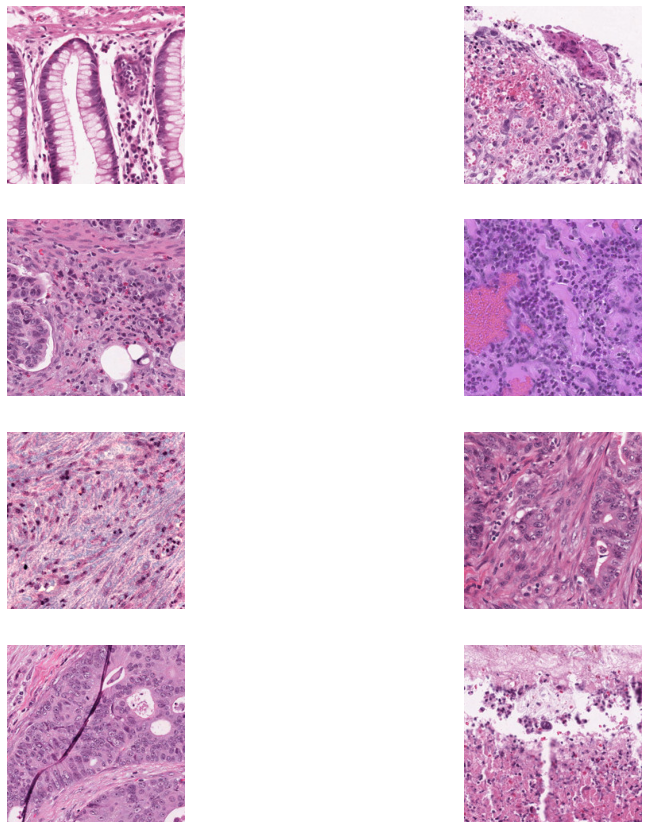

In [12]:
import matplotlib.pyplot as plt
# plot a grid of 8 images (4 images of each class)
import matplotlib.image as mpimg
#set the number of columns and rows
rows = 4
cols = 2
#set the figure size
fig = plt.gcf()
fig.set_size_inches(15,15)
#merge the covid and normal list
merged_list = mss_pic+msi_pic
for i , img_path in enumerate(merged_list):
  data= img_path.split('/', 2)[2] 
  sp = plt.subplot(rows, cols, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  #sp.set_title(data, fontsize=11)
  plt.imshow(img,cmap='gray') 

  plt.show

**Resizing all images and creating the variables x and y**

In [13]:
x = []
y = []

for i in tqdm(os.listdir(train_mss_dir)):
    path = os.path.join(train_mss_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(96,96))
    x.append(img)
    y.append('MSS')

for i in tqdm(os.listdir(train_msi_dir)):
    path = os.path.join(train_msi_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(96,96))
    x.append(img)
    y.append('MSI')

100%|██████████| 3592/3592 [00:12<00:00, 291.67it/s]


In [14]:
for i in tqdm(os.listdir(test_mss_dir)):
    path = os.path.join(test_mss_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(96,96))
    x.append(img)
    y.append('MSS')

for i in tqdm(os.listdir(test_msi_dir)):
    path = os.path.join(test_msi_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(96,96))
    x.append(img)
    y.append('MSI')

100%|██████████| 450/450 [00:01<00:00, 296.15it/s]


In [15]:
x = np.array(x)
y = np.array(y)
x.shape,y.shape

((8341, 96, 96, 3), (8341,))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


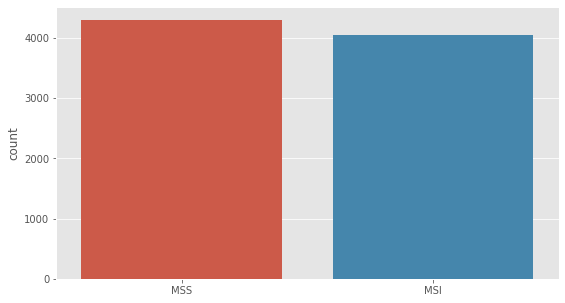

In [16]:
import seaborn as sns
plt.style.use("ggplot")
plt.figure(figsize=(9,5))
sns.countplot(y)
plt.show()

**Data labelling**

In [17]:
y

array(['MSS', 'MSS', 'MSS', ..., 'MSI', 'MSI', 'MSI'], dtype='<U3')

In [18]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

In [19]:
y = to_categorical(y)#num_classes = 2
y.shape

(8341, 2)

**Data splitting**

When developing a deep learning-based method, using a rigorous evaluation process is essential to avoid overfitting to training data or the generation of fake information. In order to evaluate the performance of the network, it is generally recommended to split data into training, valid, and test sets. The training set data are used to determine the network parameters. In most cases, the network shows good performance for the training set after

In [20]:
from sklearn.utils import shuffle
x,y = shuffle(x,y)

In [21]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [22]:
y_test.shape

(1669, 2)

**Data Augmentation**

The amount of data gathered was very low and could cause the models to under-fit. Hence, we would use a brilliant technique of Data Augmentation to increase the amount of data. This technique relies on rotations, flips, change in exposure, etc to create similar images. Using this technique we can increase the size of data by a high factor. The output image of the cropping stage is given as input to ImageDataGenerator which is a function in keras.preprocessing.image library. This function takes multiple arguments that decide how Augmentation takes place.

In [23]:
# generate training,testing and validation batches 
dgen_train = ImageDataGenerator(rescale =1./255,
                                validation_split=0.2,
                                zoom_range = 0.2,
                                horizontal_flip =True)
dgen_validation = ImageDataGenerator(rescale = 1./255)
dgen_test = ImageDataGenerator(rescale =1./255)

train_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=(96,96),
                                                 subset='training',
                                                 batch_size = 32,
                                                 class_mode = 'binary')

validation_generator = dgen_train.flow_from_directory(val_dir,
                                                 target_size=(96,96),
                                                 subset='validation',
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_generator = dgen_test.flow_from_directory(test_dir,
                                                 target_size=(96,96),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 5930 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Found 929 images belonging to 2 classes.


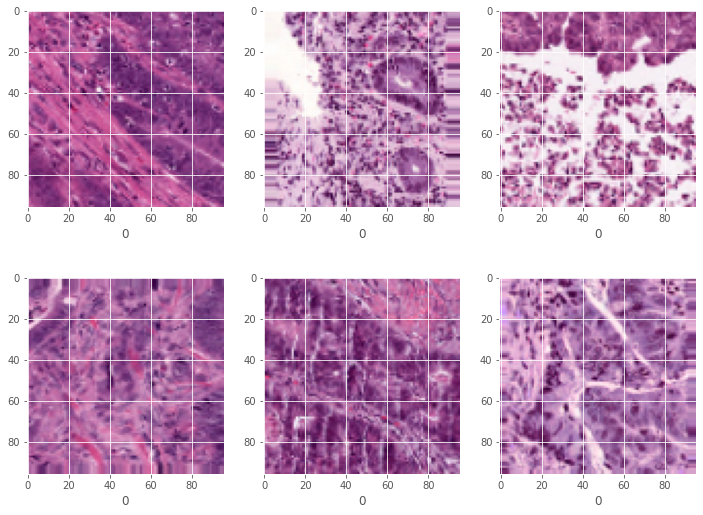

In [24]:
from tensorflow.keras.preprocessing import image
sample_x,sample_y = next(train_generator)
plt.figure(figsize=(12,9))
for i in range(6):
    plt.subplot(2,3,i+1)
    sample = image.array_to_img(sample_x[i])
    plt.xlabel(np.argmax(sample_y[i]))
    plt.imshow(sample)
plt.show()

In [25]:
#get the class indices
train_generator.class_indices

{'MSI': 0, 'MSS': 1}

In [26]:
#get the image shape
train_generator.image_shape

(96, 96, 3)

**Creating the Ensemble Model**

Our first task would be to create all the individual models. I will be creating three different models using MobileNetV2, InceptionV3, and Xception. Creating a model using a pre-trained network is very easy in Tensorflow. We need to load the weights, decide whether to freeze or unfreeze the loaded weights, and finally add Dense layers to make the output how we want. The basic structure I will be using for my models.

In [27]:
def create_model(base_model):
    base_model.trainable = True
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    prediction_layer = tf.keras.layers.Dense(2, activation='sigmoid')(global_average_layer)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics='accuracy')
    return model

In [28]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D,BatchNormalization,LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from tensorflow.keras.metrics import Metric
from typeguard import typechecked
from typing import Optional

import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPooling2D,Dropout,GlobalAveragePooling2D

In [30]:
checkpoint = ModelCheckpoint( "Ensemble" ,monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [31]:
batch_size = 32
epochs = 50
def fit_model(model):
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs, 
                        validation_data=(x_test, y_test),
                        callbacks=checkpoint)
    return history

In [32]:
IMG_SHAPE = (96, 96, 3)
base_model1 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model2 = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model3 = tf.keras.applications.Xception(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
model1 = create_model(base_model1)
model2 = create_model(base_model2)
model3 = create_model(base_model3)
history1 = fit_model(model1)
model1.save('models/model1.h5')
history2 = fit_model(model2)
model2.save('models/model2.h5')
history3 = fit_model(model3)
model3.save('models/model3.h5')

83689472/83683744 [==============================] - 1s 0us/step
Epoch 1/50
209/209 [==============================] - 47s 51ms/step - loss: 0.7114 - accuracy: 0.5949 - val_loss: 0.7763 - val_accuracy: 0.5087

Epoch 00001: val_accuracy improved from -inf to 0.50869, saving model to Ensemble
INFO:tensorflow:Assets written to: Ensemble/assets
Epoch 2/50
209/209 [==============================] - 9s 44ms/step - loss: 0.4066 - accuracy: 0.8420 - val_loss: 1.8110 - val_accuracy: 0.4943

Epoch 00002: val_accuracy did not improve from 0.50869
Epoch 3/50
209/209 [==============================] - 9s 43ms/step - loss: 0.2446 - accuracy: 0.9177 - val_loss: 0.9441 - val_accuracy: 0.5339

Epoch 00003: val_accuracy improved from 0.50869 to 0.53385, saving model to Ensemble
INFO:tensorflow:Assets written to: Ensemble/assets
Epoch 4/50
209/209 [==============================] - 9s 44ms/step - loss: 0.1349 - accuracy: 0.9617 - val_loss: 1.3362 - val_accuracy: 0.5698

Epoch 00004: val_accuracy improved

**Model Performance Evaluation**


In [33]:
#get the keys of history object
history1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

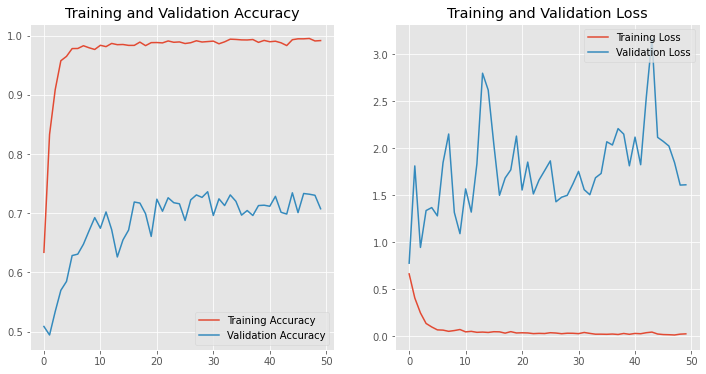

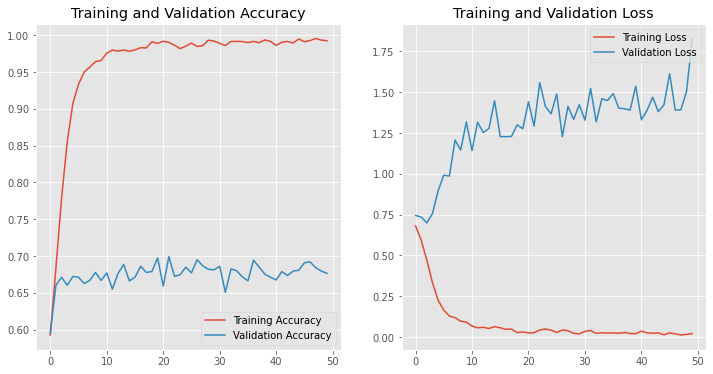

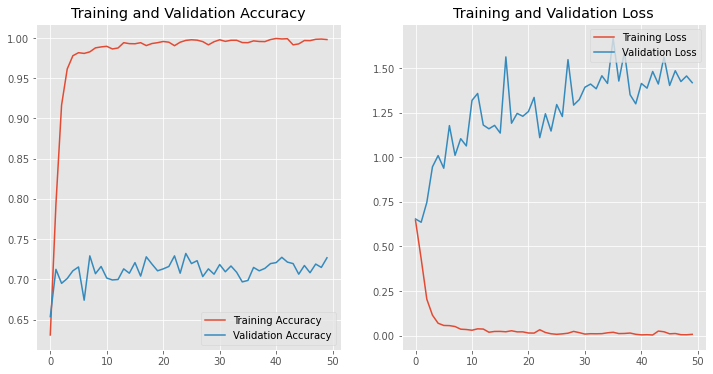

In [35]:
plot_history(history1)
plot_history(history2)
plot_history(history3)

**Assessing metrics performance scores**

In [36]:
print('MobileNetV2 acc:', history1.history['accuracy'][-1])
print('InceptionV3 acc:', history2.history['accuracy'][-1])
print('Xception acc:', history3.history['accuracy'][-1])

MobileNetV2 acc: 0.9917566180229187
InceptionV3 acc: 0.992655873298645
Xception acc: 0.9980515837669373


In [37]:
print('MobileNetV2 validation acc:', history1.history['val_accuracy'][-1])
print('InceptionV3 validation acc:', history2.history['val_accuracy'][-1])
print('Xception validation acc:', history3.history['val_accuracy'][-1])

MobileNetV2 validation acc: 0.7076093554496765
InceptionV3 validation acc: 0.6764529943466187
Xception validation acc: 0.726782500743866


In [38]:
print('MobileNetV2 loss:', history1.history['loss'][-1])
print('InceptionV3 loss:', history2.history['loss'][-1])
print('Xception loss:', history3.history['loss'][-1])

MobileNetV2 loss: 0.024866575375199318
InceptionV3 loss: 0.02180003747344017
Xception loss: 0.006706330459564924


In [39]:
print('MobileNetV2 validation loss:', history1.history['val_loss'][-1])
print('InceptionV3 validation loss:', history2.history['val_loss'][-1])
print('Xception validation loss:', history3.history['val_loss'][-1])

MobileNetV2 validation loss: 1.6102031469345093
InceptionV3 validation loss: 1.8287895917892456
Xception validation loss: 1.4179649353027344


The results are not at all bad but we will still improve them.

**Load the Model and Freeze its Layers**

Our next step is to load the models we have just created above and freeze their layers so that their weights are not altered when we fit our ensemble model on them.

In [40]:
def load_all_models():
    all_models = []
    model_names = ['model1.h5', 'model2.h5', 'model3.h5']
    for model_name in model_names:
        filename = os.path.join('models', model_name)
        model = tf.keras.models.load_model(filename)
        all_models.append(model)
        print('loaded:', filename)
    return all_models

**Define more metrics for binary classification**

In [41]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [42]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

**Concatenate their outputs and add Dense Layers**

Take the outputs of all the models and put them in a concatenation layer. Then add a Dense layer with some units followed by a Dense layer with a single output and an activation equal to “softmax” as our task is a categorical classification. This can be thought of as an ANN where the predictions of all the models are taken as inputs and an output is provided.

In [43]:
def ensemble_model(models):
    for i, model in enumerate(models):
        for layer in model.layers:
          layer.trainable = False
          ensemble_visible = [model.input for model in models]
          ensemble_outputs = [model.output for model in models]
          merge = tf.keras.layers.concatenate(ensemble_outputs)
          merge = tf.keras.layers.Dense(10, activation='relu')(merge)
          output = tf.keras.layers.Dense(2, activation='sigmoid')(merge)
          model = tf.keras.models.Model(inputs=ensemble_visible, outputs=output)
          model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics = METRICS)
          
          return model

In [44]:
models = load_all_models()
model = ensemble_model(models)

loaded: models/model1.h5
loaded: models/model2.h5
loaded: models/model3.h5


**Training the ensemble model**

We cannot train the ensemble model normally by just passing the dataset like how we trained our individual models. Inputs are required at three places while only one output is generated. So we will need to configure our X values like that.

In [45]:
X = [x_train for _ in range(len(model.input))]
X_1 = [x_test for _ in range(len(model.input))]

In [46]:
epochs = 50
history = model.fit(X, y_train,
                    batch_size=32,
                    epochs=epochs,
                    validation_data=(X_1, y_test),
                    )

Epoch 1/50
209/209 [==============================] - 67s 252ms/step - loss: 0.7559 - binary_accuracy: 0.5340 - precision: 0.5353 - recall: 0.5235 - auc: 0.4459 - f1_score: 0.5297 - val_loss: 0.7067 - val_binary_accuracy: 0.5153 - val_precision: 0.5153 - val_recall: 0.5153 - val_auc: 0.6027 - val_f1_score: 0.5198
Epoch 2/50
209/209 [==============================] - 49s 234ms/step - loss: 0.5098 - binary_accuracy: 0.8441 - precision: 0.8621 - recall: 0.8172 - auc: 0.9190 - f1_score: 0.8371 - val_loss: 0.6373 - val_binary_accuracy: 0.6291 - val_precision: 0.6326 - val_recall: 0.6159 - val_auc: 0.6982 - val_f1_score: 0.6265
Epoch 3/50
209/209 [==============================] - 49s 236ms/step - loss: 0.4497 - binary_accuracy: 0.9729 - precision: 0.9772 - recall: 0.9684 - auc: 0.9898 - f1_score: 0.9724 - val_loss: 0.6374 - val_binary_accuracy: 0.6483 - val_precision: 0.6531 - val_recall: 0.6327 - val_auc: 0.7095 - val_f1_score: 0.6447
Epoch 4/50
209/209 [==============================] - 4

In [47]:
def plot_history(history):
    bin_acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, bin_acc, label='Ensemble model Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Ensemble model Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Ensemble model Training Loss')
    plt.plot(epochs_range, val_loss, label='Ensemble model Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()

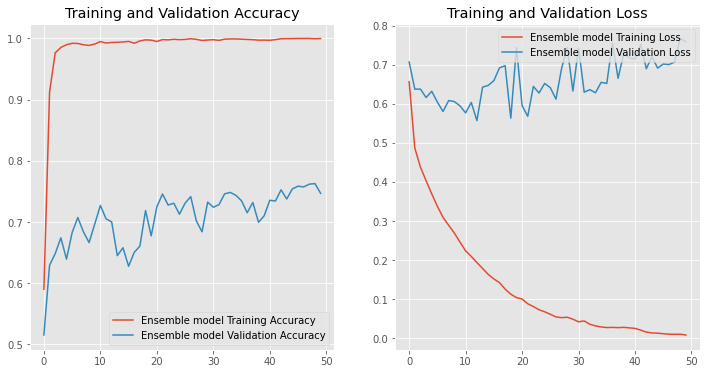

In [48]:
plot_history(history)

In [49]:
print('Ensemble accuracy:', history.history['binary_accuracy'][-1])
print('Ensemble validation accuracy:', history.history['val_binary_accuracy'][-1])
print('Ensemble loss:', history.history['loss'][-1])
print('Ensemble validation loss:', history.history['val_loss'][-1])

Ensemble accuracy: 0.9998500943183899
Ensemble validation accuracy: 0.7468544244766235
Ensemble loss: 0.008306642062962055
Ensemble validation loss: 0.7585614323616028


As we can see, we got an overall val_categorical_accuracy, and val_loss better with the Ensemble model with a score of 75%.

**Classification Report**

We evaluate Pecision, Recall, F1score, and Support for the model.

In [50]:
y_pred= model.predict(X_1)
y_pred = np.argmax(y_pred,axis=1)
unique,counts = np.unique(y_pred,return_counts=True)
print(unique,counts)
y_test_new = np.argmax(y_test,axis=1)

[0 1] [914 755]


**Confusion Matrix**

In [51]:
from sklearn.metrics import classification_report,confusion_matrix

In [52]:
clf_report = classification_report(y_test_new,y_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.71      0.80      0.76       809
           1       0.79      0.69      0.74       860

    accuracy                           0.75      1669
   macro avg       0.75      0.75      0.75      1669
weighted avg       0.75      0.75      0.75      1669



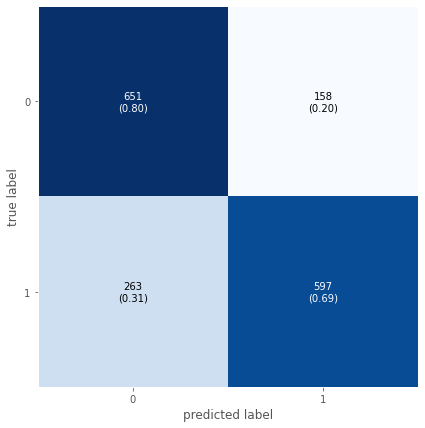

In [53]:

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test_new,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),
                     show_normed=True);

As we can see, we got excellent scores using the Ensemble model.

**Model Performance**

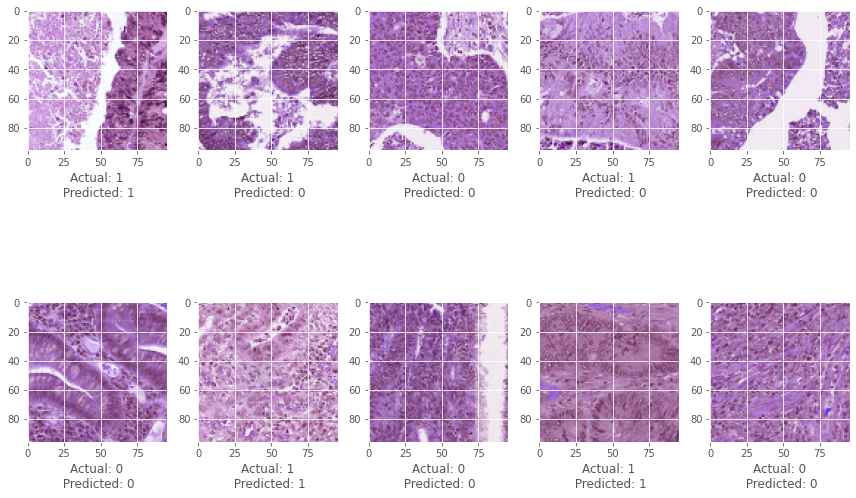

In [54]:
plt.figure(figsize=(12,9))
for i in range(10):
    sample_idx = random.choice(range(len(x_test)))
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[sample_idx])
    plt.xlabel(f"Actual: {y_test_new[sample_idx]}\n Predicted: {y_pred[sample_idx]}")
    
plt.tight_layout()
plt.show()